<a href="https://colab.research.google.com/github/uccio999/bestgliwice-mlcourse/blob/main/Best_lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI in Medicine: Image Classification with CNN on OrganAMNIST

This Colab notebook demonstrates a simple Convolutional Neural Network (CNN) for classifying organs in axial CT scans using the OrganAMNIST dataset from MedMNIST. We'll train the model, visualize training progress, evaluate metrics, and use Grad-CAM for explainability.

In [ ]:
# install dependencies
!pip install medmnist grad-cam

In [ ]:
#Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
# Load the OrganAMNIST dataset
data_flag = 'organamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Transformations: Normalize to [-1, 1] as per MedMNIST recommendation for grayscale
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Download and load datasets
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

# Data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset info: {info['description']}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
print(f"Classes: {info['label']}")

In [ ]:
# Visualize a mosaic of sample images
def show_mosaic(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i in range(num_images):
        img, label = dataset[i]
        ax = axes[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {info['label'][str(label.item())]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_mosaic(train_dataset)

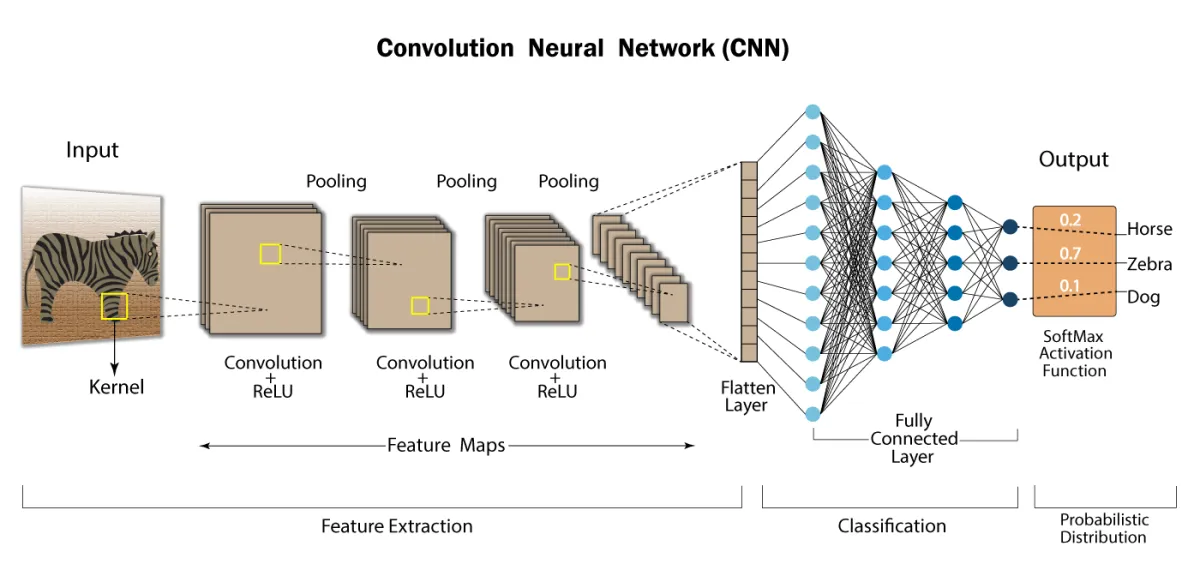

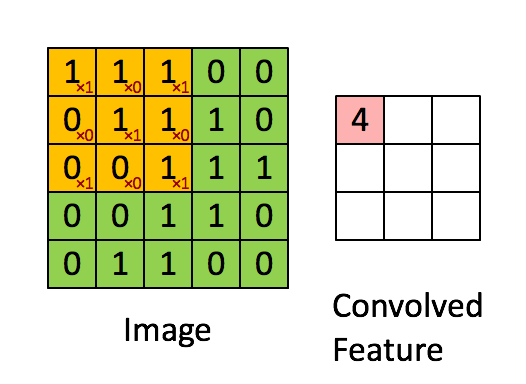

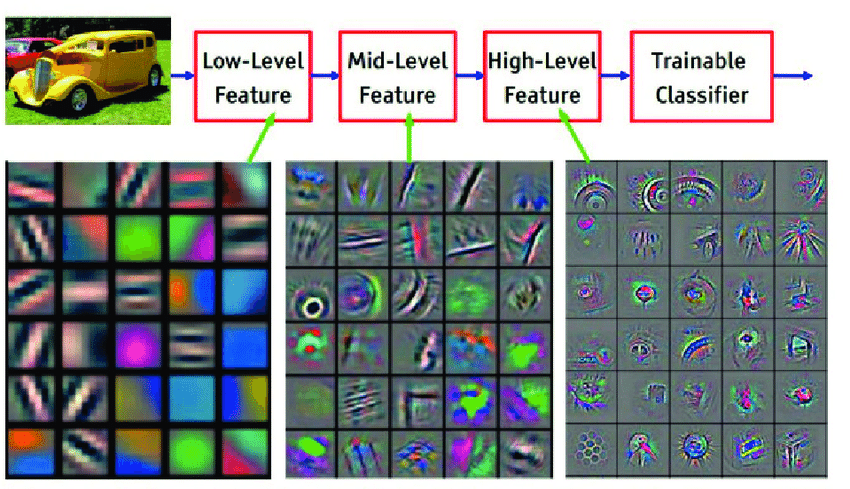

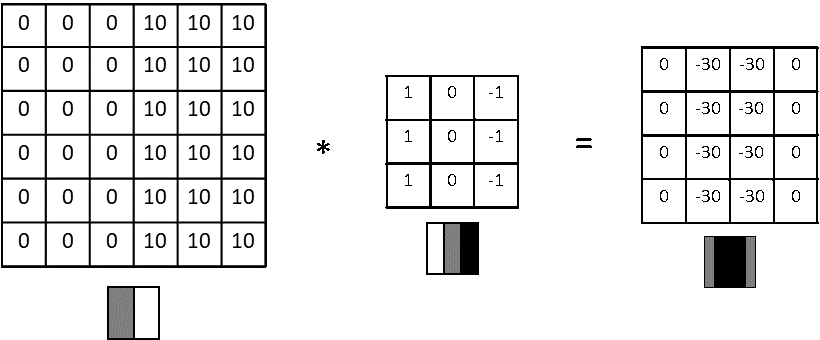

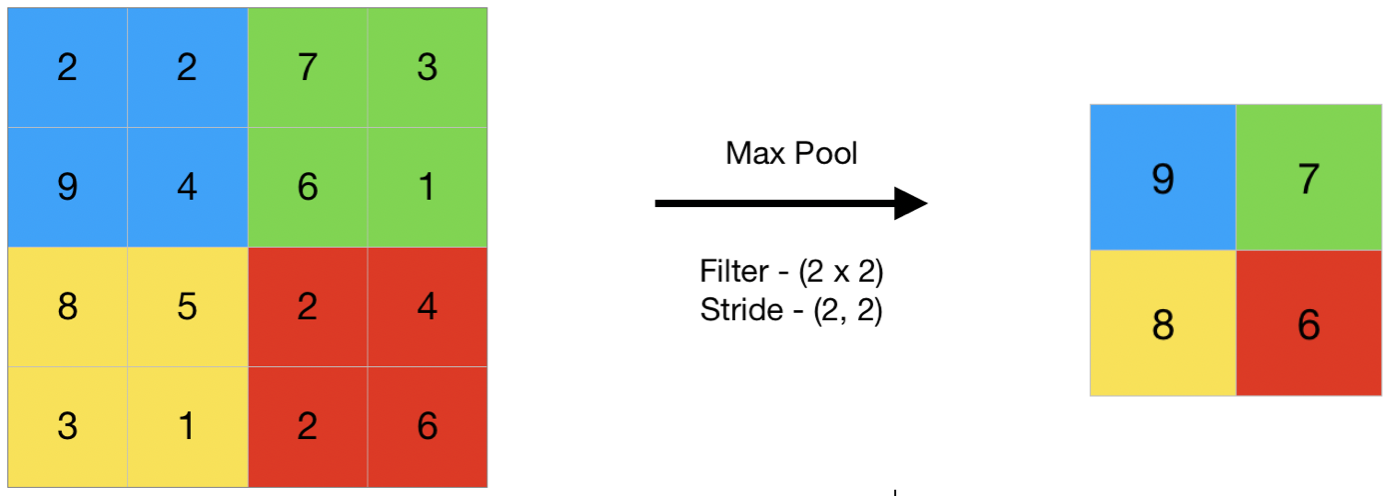

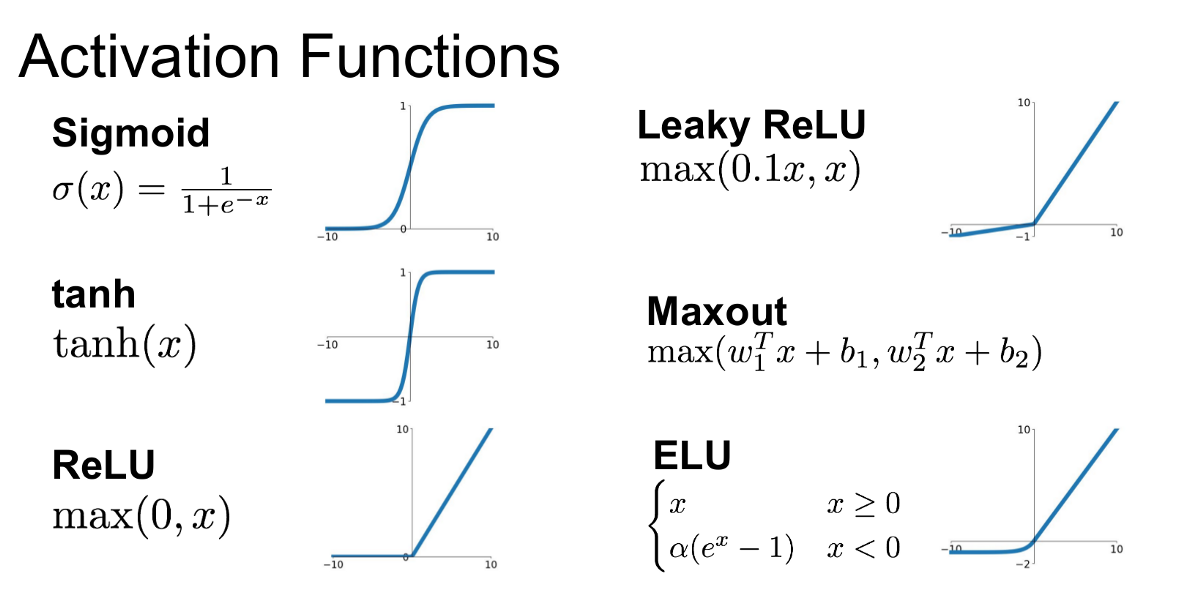

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, device, loss, and optimizer
model = SimpleCNN(num_classes=len(info['label']))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Using device: {device}")

In [ ]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(1)  # Labels are [B, 1] -> [B]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100. * correct / total)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).squeeze(1)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_accs.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_accs[-1]:.2f}%")

In [ ]:
# Plot training graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# Evaluate metrics on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(1)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

# For more metrics, you could add confusion matrix, precision, recall, etc., using sklearn.metrics

In [ ]:
# Visualize Grad-CAM heatmaps for explainability
# Select target layer for Grad-CAM (last conv layer)
target_layers = [model.conv2]

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=target_layers)

# Function to show Grad-CAM for a sample
def show_gradcam(dataset, index, target_category=None):
    input_tensor, label = dataset[index]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dim
    if target_category is None:
        target_category = int(label.item())  # Use true label
    else:
        target_category = int(target_category)

    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])

    # Unnormalize image for visualization
    img = input_tensor.cpu().squeeze().numpy()
    img = (img * 0.5) + 0.5  # Unnormalize from [-1,1] to [0,1]

    # Convert grayscale to RGB by repeating channels
    rgb_img = np.repeat(img[..., np.newaxis], 3, axis=-1)

    # Overlay CAM on image
    visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: True Label {info['label'][str(label.item())]}, Target Class {target_category}")
    plt.axis('off')
    plt.show()

# Show for a few test samples (change indices as needed)
show_gradcam(test_dataset, 0)  # Using true label
show_gradcam(test_dataset, 1)
show_gradcam(test_dataset, 2)